# Example of heatmap generation
This notebook shows an example of heatmap label generation for DHP19 dataset. 
Run the notebook after generating the DHP19 accumulated images/labels (in .h5 format) from the .aedat recordings and .mat 3D joint positions labels.

In [1]:
import h5py
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import cv2

def load_file_(filepath):
    if filepath.endswith('.h5'):
        with h5py.File(filepath, 'r') as f_:
            data = (f_[list(f_.keys())[0]])[()]
    else:
        raise ValueError('.h5 required format.')
    return data

def decay_heatmap(heatmap, sigma2=4):
    heatmap = cv2.GaussianBlur(heatmap,(0,0),sigma2)
    heatmap /= np.max(heatmap) # to keep the max to 1
    return heatmap

Change the paths and parameters in the next cell 

In [2]:
# path of files generated using matlab 
path_ = ''
# camera projection matrices path
P_mat_dir = ''

image_h, image_w, num_joints = 260, 346, 13 # depend on how accumulated frames are generated in Matlab

t  = 19 # timestep of image to plot
subj, sess, mov = 2, 4, 6
decay_maps_flag = True # True to blur heatmaps
ch_idx = 3 # 0 to 3. This is the order of channels in .aedat/.h5

NB: the order of channels in the .aedat file (and in the saved .h5) is different from the camera index. 
The next cell takes care of this, loading the proper camera projection matrix.

In [3]:
if ch_idx==1:
    P_mat_cam = np.load(join(P_mat_dir,'P1.npy'))
elif ch_idx==3:
    P_mat_cam = np.load(join(P_mat_dir,'P2.npy'))
elif ch_idx==2:
    P_mat_cam = np.load(join(P_mat_dir,'P3.npy'))
elif ch_idx==0:
    P_mat_cam = np.load(join(P_mat_dir,'P4.npy'))

load files of images and labels, and select the single sample t to plot

In [4]:
vicon_xyz_all = load_file_(join(path_, 'S{}_session{}_mov{}_7500events_label.h5'.format(subj,sess,mov)))
images_all = load_file_(join(path_, 'S{}_session{}_mov{}_7500events.h5'.format(subj,sess,mov)))
vicon_xyz = vicon_xyz_all[t]
image = images_all[t, :, :, ch_idx]

Algorithm to convert XYZ Vicon coordinates to UV pixel coordinates

In [5]:
# use homogeneous coordinates representation to project 3d XYZ coordinates to 2d UV pixel coordinates.
vicon_xyz_homog = np.concatenate([vicon_xyz, np.ones([1,13])], axis=0)
coord_pix_all_cam2_homog = np.matmul(P_mat_cam, vicon_xyz_homog)
coord_pix_all_cam2_homog_norm = coord_pix_all_cam2_homog/coord_pix_all_cam2_homog[-1]
u = coord_pix_all_cam2_homog_norm[0]
v = image_h - coord_pix_all_cam2_homog_norm[1] # flip v coordinate to match the image direction

# mask is used to make sure that pixel positions are in frame range.
mask = np.ones(u.shape).astype(np.float32)
mask[u>image_w] = 0
mask[u<=0] = 0
mask[v>image_h] = 0
mask[v<=0] = 0

# pixel coordinates
u = u.astype(np.int32)
v = v.astype(np.int32)

Generate the heatmaps and plot them over the image

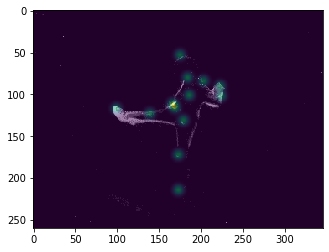

In [7]:
# initialize the heatmaps
label_heatmaps = np.zeros((image_h, image_w, num_joints))

k = 2 # constant used to better visualize the joints when not using decay

for fmidx,pair in enumerate(zip(v,u, mask)):
    if decay_maps_flag:
        if pair[2]==1: # write joint position only when projection within frame boundaries
            label_heatmaps[pair[0],pair[1], fmidx] = 1
            label_heatmaps[:,:,fmidx] = decay_heatmap(label_heatmaps[:,:,fmidx])
    else:
        if pair[2]==1: # write joint position only when projection within frame boundaries
            label_heatmaps[(pair[0]-k):(pair[0]+k+1),(pair[1]-k):(pair[1]+k+1), fmidx] = 1

plt.figure()
plt.imshow(image, cmap='gray')
plt.imshow(np.sum(label_heatmaps, axis=-1), alpha=.5)
plt.show()